# On-policy Bandit Algorithms
*This notebook is complementary material for the [Practical Bandits - An Industry Perspective](https://sites.google.com/view/practical-bandits-tutorial) tutorial at The Web Conference 2023 - Austin, Texas. Tutorial slides are available [the tutorial website](https://sites.google.com/view/practical-bandits-tutorial).*

## About this notebook
Understanding how to apply counterfactual learning approaches in practise can be overwhelming. 

In this notebook, we implement a few basic on-policy Bandit Algorithms to supplement the methods described in the tutorial slides. 

### What you will learn by going through this notebook
1. How basic algorithms such as UCB and Explore-and-commit can be implemented.
1. How to use [Open Bandit Pipeline](https://github.com/st-tech/zr-obp) to create some basic simulations for benchmarking on-policy bandit algorithms.

In [1]:
import numpy as np

from obp.dataset import logistic_sparse_reward_function
from obp.policy import Random, EpsilonGreedy

from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator

## Implementing on-policy algorithms

### Explore-the-Commit 

In [2]:
from obp.policy import BaseContextFreePolicy
from dataclasses import dataclass

@dataclass
class ExploreThenCommit(BaseContextFreePolicy):
    explore_rounds: float = None

    def __post_init__(self) -> None:
        """Initialize class."""
        super().__post_init__()
        self.policy_name = f"ETC-{self.explore_rounds}-rounds"
        self.mean_rewards = np.ones(self.n_actions)
        self.reward = np.ones(self.n_actions)
        self.arm_pulls = np.ones(self.n_actions)
        self.total_rounds = 0

    def select_action(self) -> np.ndarray:
        if self.total_rounds < self.explore_rounds:
            return [self.total_rounds % self.n_actions]
        else:
            return [np.argmax(self.mean_rewards)]

    def update_params(self, action: int, reward: float) -> None:
        self.reward[action] += reward
        self.arm_pulls[action] += 1
        self.total_rounds += 1

        self.mean_rewards[action] = self.reward[action]/self.arm_pulls[action]


### Upper Confidence Bound (UCB)

In [3]:
@dataclass
class UpperConfidenceBound(BaseContextFreePolicy):
    delta: float = None
    policy_name: str = "UCB"

    def __post_init__(self) -> None:
        """Initialize class."""
        super().__post_init__()
        self.upper_confidence_bounds = np.ones(self.n_actions) * np.inf
        self.reward = np.ones(self.n_actions)
        self.arm_pulls = np.ones(self.n_actions)

    def select_action(self) -> np.ndarray:
        return [np.argmax(self.upper_confidence_bounds)]

    def update_params(self, action: int, reward: float) -> None:
        self.reward[action] += reward
        self.arm_pulls[action] += 1

        mean_reward = self.reward[action]/self.arm_pulls[action]
        self.upper_confidence_bounds[action] = mean_reward + np.sqrt(2 * np.log(1/self.delta) / self.arm_pulls[action])



### Simulation setup


In [4]:
n_actions = 10
dim_context = 1
n_rounds = 50000

# Create random uniform rewards for each arm, except for one that is the optimal arm
true_mean_rewards = np.random.uniform(0, .1, size=(n_actions))
true_mean_rewards[1] = .12

def bernoulli_reward(context, **kwargs):
    n_rounds = context.shape[0]
    return np.tile(true_mean_rewards, (n_rounds, 1))

env = BanditEnvironmentSimulator(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_type="binary", # "binary" or "continuous"
    reward_function=bernoulli_reward,
    random_state=12345,
)



### Simulating the on-policy algorithms


In [5]:
bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.20, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.05, "random_state": 12345}),
    (ExploreThenCommit, {"n_actions": n_actions, "explore_rounds": 1000, "random_state": 12345}),
    (ExploreThenCommit, {"n_actions": n_actions, "explore_rounds": 100, "random_state": 12345}),
    (UpperConfidenceBound, {"n_actions": n_actions, "delta": .9, "random_state": 12345}),
]

training_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)

cumulative_rewards = {}
for policy_class, args in bandit_policies:
    policy = policy_class(**args)

    training_simulator = BanditPolicySimulator(policy=policy)

    training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
    cumulative_rewards[policy.policy_name] = np.cumsum(training_simulator.obtained_rewards)


100%|██████████| 50000/50000 [00:00<00:00, 162079.29it/s]


### Results
The plot below demonstrates the cumulative reward for each of the on-policy models at the first and last 1000 rounds, which give us the follow observations.

*Epsilon greedy with a well-picked $\epsilon$ (0.05 in the example) does great on the short term, but is suboptimal in the long term*. As mentioned in the tutorial slides, with a good epsilon we do end up finding the optimal arm. However, the continous exploration is sacrifising performing in the long-term. 

*ETC is among the top performers*, which is not unsurprising giving our setup. With just 1000 rounds of exploration, ETC is able to identify the optimal arm. However, when ETC is exploring insufficiently (100 rounds) is among the lowest performers. In reality it is almost impossible picking a good number of explore rounds.

*UCB performs about the same as the optimally picked ETC*. This shows the power of UCB, as the selection of exploration rate of UCB is automatically adjusted based on uncertainty. 

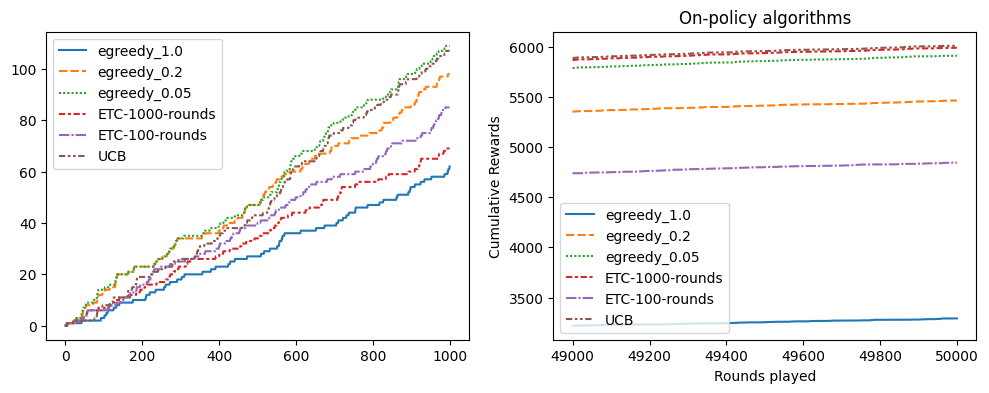

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(cumulative_rewards)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

sns.lineplot(data=df.iloc[:1000], ax=axes[0])
sns.lineplot(data=df[-1000:], ax=axes[1])


plt.xlabel('Rounds played')
plt.ylabel('Cumulative Rewards')
plt.title('On-policy algorithms')

plt.show()